# Import


In [1]:
import os
import tensorflow as tf
import IPython.display as display
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import PIL.Image
import time
import functools
import tensorflow_hub as hub
import cv2
from tensorflow.keras import layers
from tensorflow.keras.applications import vgg19 , VGG19
from tensorflow.keras.models import Model

os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Load Image

In [ ]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [ ]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels = 3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  pic_dim = max(shape)
  scale = max_dim / pic_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = tf.expand_dims(img,axis=0)
  return img

In [ ]:
def imshow(image):
  if len(image.shape) > 3: #squeeze array to drop batch axis
    image = tf.squeeze(image, axis=0)
  plt.imshow(image)

65536/49332 [=======================================] - 0s 0us/step


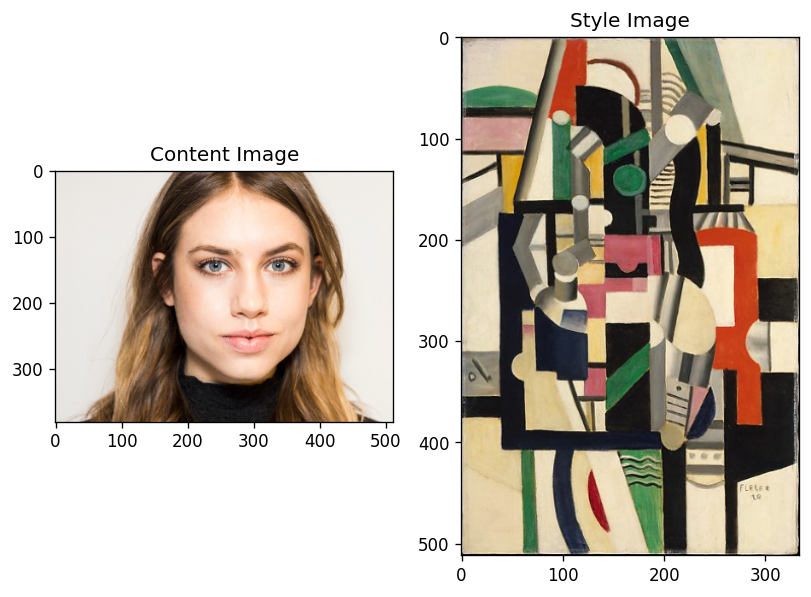

In [ ]:
content_path = tf.keras.utils.get_file(origin='https://media.glamour.com/photos/5a425fd3b6bcee68da9f86f8/master/pass/best-face-oil.png')
style_path = tf.keras.utils.get_file(origin='https://collectionapi.metmuseum.org/api/collection/v1/iiif/489989/1005214/restricted')

content_image = load_img(content_path)
style_image = load_img(style_path)

plt.figure(figsize=(8, 6), dpi=120)
plt.subplot(1, 2, 1)
plt.title('Content Image')
imshow(content_image)


plt.subplot(1, 2, 2)
plt.title('Style Image')
imshow(style_image)

In [ ]:
processed_input = vgg19.preprocess_input(content_image*255)
reshape_input = tf.image.resize(processed_input,(224,224))

# Vgg 19

In [ ]:
vgg19_model = VGG19(include_top = False, weights = 'imagenet')


content_layers = ['block4_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1',
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

80150528/80134624 [==============================] - 1s 0us/step


In [ ]:
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top = False, weights = 'imagenet')
  vgg.trainable = False
  outputs = []
  for name in layer_names:
    outputs.append(vgg.get_layer(name).output)

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [ ]:
style_extractor = vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)

In [ ]:
def gram_matrix(tensor):
  channels=int(tensor.shape[-1])
  vector=tf.reshape(tensor,[-1,channels])
  n=tf.shape(vector)[0]
  gram_matrix=tf.matmul(vector,vector,transpose_a=True)
  return gram_matrix/tf.cast(n,tf.float32)

In [ ]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()

    self.vgg = vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False
    
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    

  def call(self, inputs):
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name: value
                    for content_name, value
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name: value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content': content_dict, 'style': style_dict}

In [ ]:
extractor = StyleContentModel(style_layers, content_layers)

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [ ]:
def normalrize(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [ ]:
optim = tf.optimizers.Adam(learning_rate=0.005, beta_1=0.99, epsilon=1e-1)

In [ ]:
style_weight= 100
content_weight= 1

In [ ]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = 0
    for name in style_outputs.keys():
      style_loss += tf.reduce_sum((style_outputs[name]-style_targets[name])**2) 
    style_loss /= (2*(style_image.shape[1]*style_image.shape[2]) * 3) 
                          
    content_loss = 0
    for name in content_outputs.keys():
      content_loss += tf.reduce_sum((content_outputs[name]-content_targets[name])**2) / 4
    

    loss = style_weight * style_loss + content_weight * content_loss
    return loss

In [ ]:
total_variation_weight= 0

In [ ]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  optim.apply_gradients([(grad, image)])
  image.assign(normalrize(image))

epoch 0 :####################

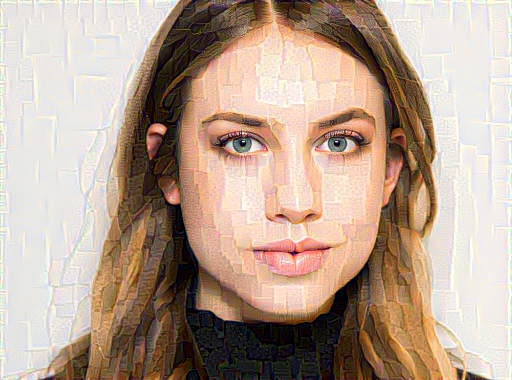

Train step: 20
epoch 1 :####################

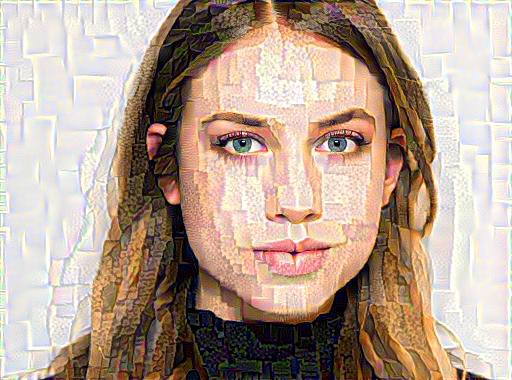

Train step: 40
epoch 2 :####################

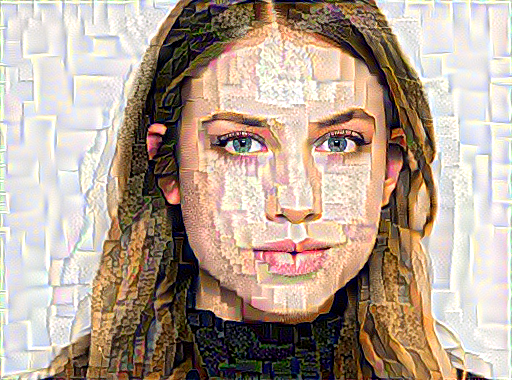

Train step: 60
epoch 3 :####################

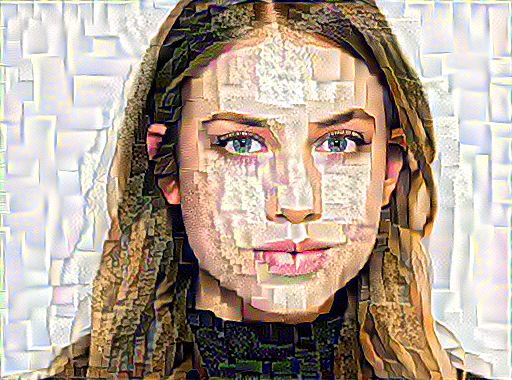

Train step: 80
epoch 4 :####################

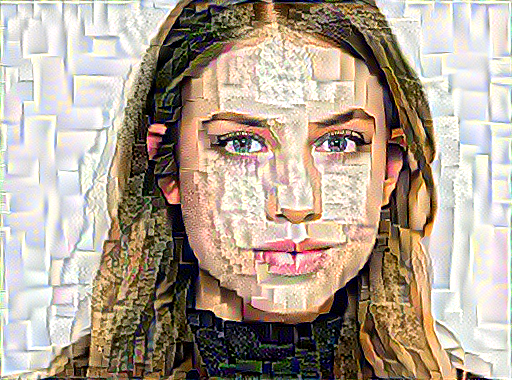

Train step: 100


In [ ]:
image = tf.Variable(content_image)
epochs = 5
steps = 20

step = 0
for n in range(epochs):
  print("epoch",n,":",end="")
  for m in range(steps):
    step += 1
    train_step(image)
    print("#", end='', flush=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))

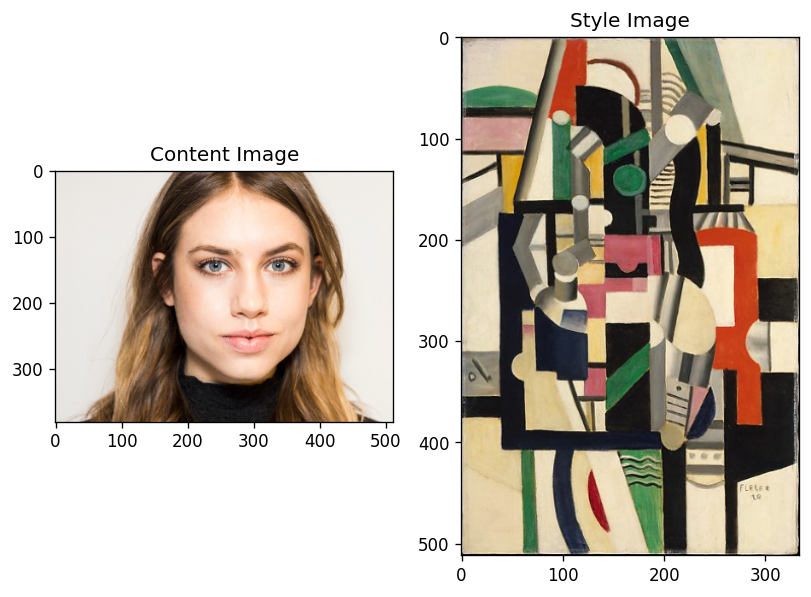

In [ ]:
plt.figure(figsize=(8, 6), dpi=120)
plt.subplot(1, 2, 1)
plt.title('Content Image')
imshow(content_image)


plt.subplot(1, 2, 2)
plt.title('Style Image')
imshow(style_image)

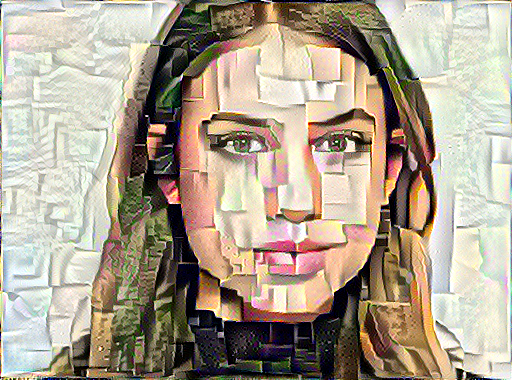

In [ ]:
display.display(tensor_to_image(image))

# Target model


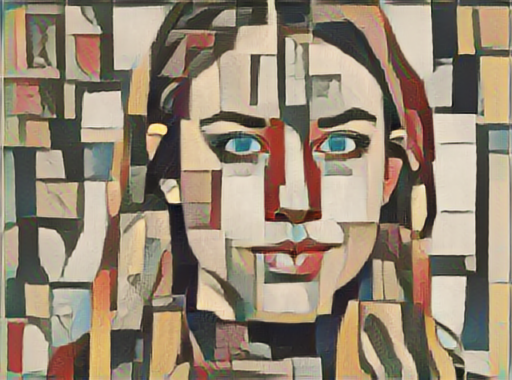

In [ ]:
hub_model = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)